In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

/Users/louis/mambaforge/envs/dlux/lib/python3.10/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import pickle as p
import equinox as eqx
import optax
import functools as ft

In [3]:
from dLux import *
from helpers import *
from bayes import *

from tqdm.notebook import tqdm
from dLux.zernike import zernike_basis
from model_layers import toliman_layers
from chainconsumer import ChainConsumer

In [4]:
plt.figure()
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["text.usetex"] = 'true'
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.dpi'] = 120

<Figure size 432x288 with 0 Axes>

In [5]:
r = arcsec2rad(10)
positions = np.array([[r/2, 0], [-r/2, 0]])
fluxes = np.array([1e6, 1e6])
wavels = 1e-9 * np.linspace(545, 645, 9)

In [6]:
# Base layers
lays = toliman_layers()
aperture = lays[2].array
wf_npix = aperture.shape[0]

# Zernike Basis
zern_basis = zernike_basis(10, wf_npix, outside=0.)[3:]
zcoeffs = np.zeros(len(zern_basis))

# Masks
test_mask = phase2opd(scale_mask(np.load("binary_mask.npy"), wf_npix), wavels.mean())
ttol_mask = phase2opd(np.pi*scale_mask(np.load("ttol_mask.npy"), wf_npix), wavels.mean())

# Detector Layers
jitter = 1.
saturation = 1e6
det_layers = [ApplyJitter(jitter), ApplySaturation(saturation)]
det_layers = []

In [7]:
# Test Osys
test_layers = toliman_layers([
    ApplyOPD(test_mask),
    ApplyBasisOPD(zern_basis, zcoeffs)])
test_osys = OpticalSystem(test_layers, 
                            wavels=wavels, 
                            positions=positions, 
                            fluxes=fluxes,
                            detector_layers=det_layers)


tol_layers = toliman_layers([
    ApplyOPD(ttol_mask),
    ApplyBasisOPD(zern_basis, zcoeffs)])
tol_osys = OpticalSystem(tol_layers, 
                         wavels=wavels, 
                         positions=positions, 
                         fluxes=fluxes,
                         detector_layers=det_layers)


airy_layers = toliman_layers([
    ApplyBasisOPD(zern_basis, zcoeffs)])
airy_osys = OpticalSystem(airy_layers, 
                          wavels=wavels, 
                          positions=positions, 
                          fluxes=fluxes,
                          detector_layers=det_layers)

In [8]:
models = [test_osys, tol_osys, airy_osys]
masks = [test_mask, ttol_mask, aperture]
names = ["Test", "Tol", "Airy"]
psfs = [model() for model in models]

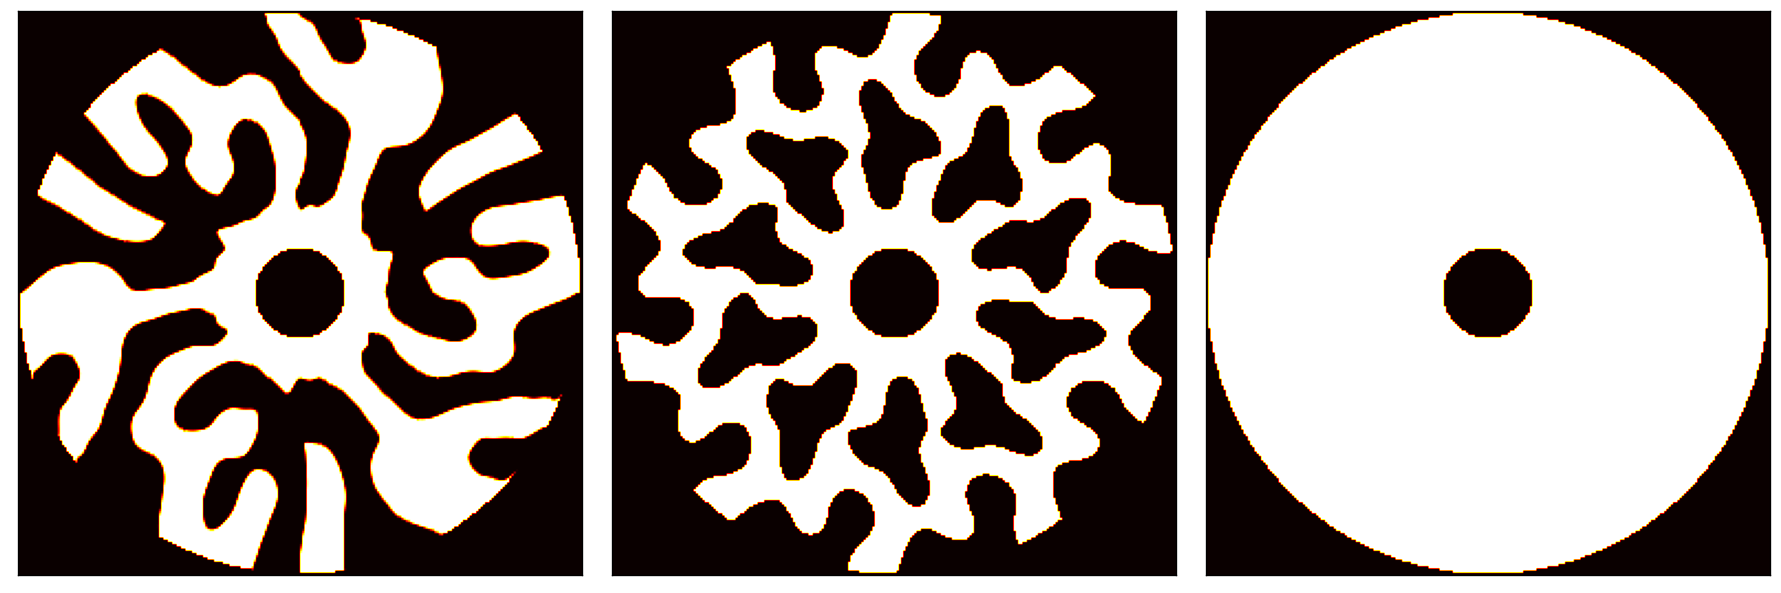

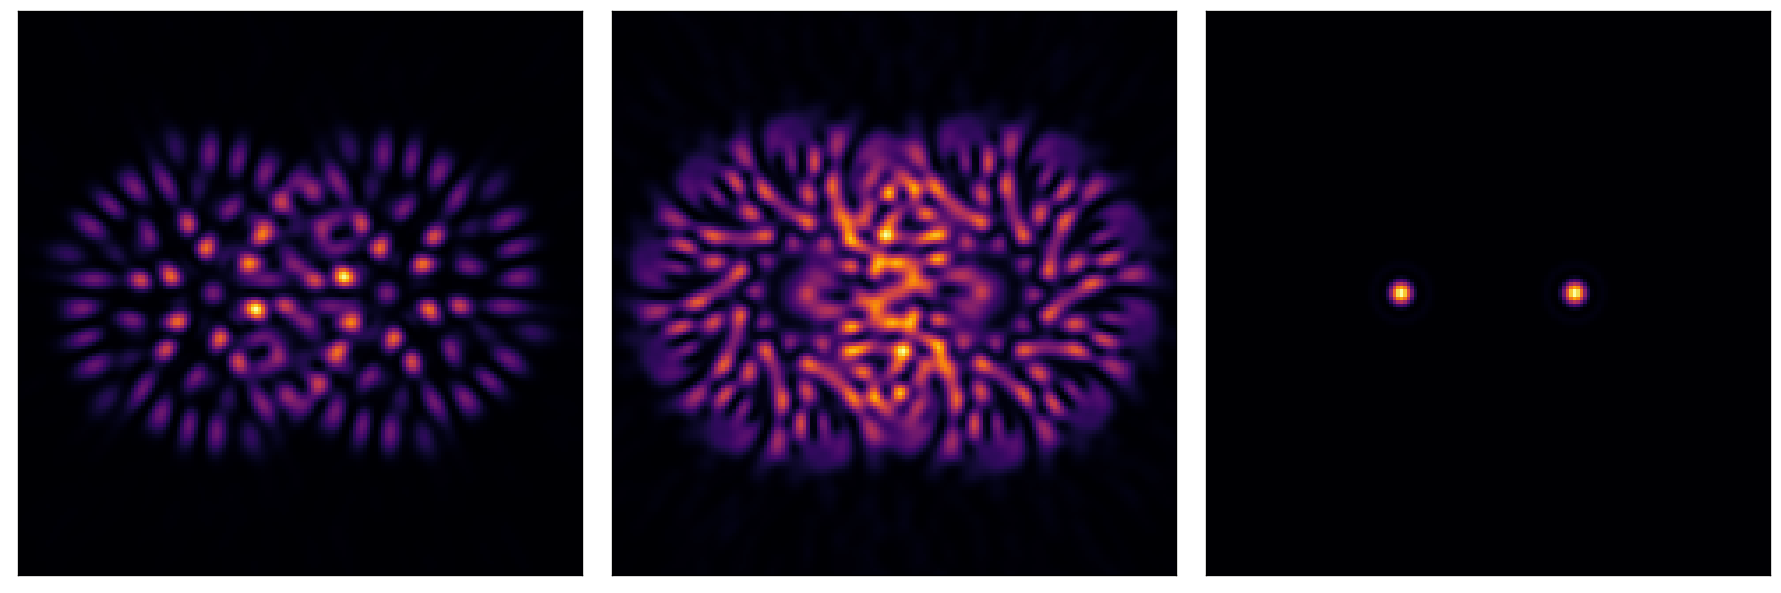

In [9]:
# plt.figure(figsize=(15, 4))
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(aperture * masks[i], cmap='hot')
    # plt.title("{} Mask".format(names[i]))
    # plt.colorbar()
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.savefig("Masks", facecolor='None', dpi=300)
plt.show()

c = psfs[0].shape[0]//2
s = 80

# plt.figure(figsize=(15, 4))
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(psfs[i][c-s:c+s, c-s:c+s])
    # plt.title("{} PSF: {:.2f}".format(names[i], np.max(psfs[i])))
    plt.xticks([])
    plt.yticks([])
    # plt.colorbar()
plt.tight_layout()
plt.savefig("Psfs", facecolor='None', dpi=300)
plt.show()

In [10]:
from jax.scipy.stats import norm

def perturb_r_phi(positions, r_shift, phi_shift):
    """
    Perturbs binary by separation and angle
    """
    p0, p1 = positions
    dp = p1 - p0
    r, phi = cart2polar(dp[0], dp[1])
    
    r += r_shift
    phi += phi_shift
    shift = polar2cart(r, phi)
    
    positions = np.array([p1 - shift, p0 + shift])
    return positions

def perturb_flux(fluxes, cont_shift):
    """
    Perturbs binary by contrast
    """
    f0, f1 = fluxes
    cont = fluxes[0]/fluxes[1]
    cont += cont_shift
    fluxes = np.array([cont*f1, f0/cont])
    return fluxes

def binary_param(X, model, get_params=False, prior=False):
    
    if get_params:
        X = np.zeros(100)
    indx = 0
    params = []
    
    # Positions
    r_shift = arcsec2rad(X[indx])
    r_shift *= 1 if prior else 1
    phi_shift = arcsec2rad(X[indx+1])
    phi_shift *= 1 if prior else 1
    positions = perturb_r_phi(model.positions, r_shift, phi_shift)
    model = eqx.tree_at(lambda model: model.positions, model, positions)
    params+= ["r (arcsec)", "$\phi (arcsec)$"]
    indx += 2
    
    # Fluxes
    cont_shift = X[indx]
    cont_shift *= 1 if prior else 1
    fluxes = perturb_flux(model.fluxes, cont_shift)
    model = eqx.tree_at(lambda model: model.fluxes, model, fluxes)
    params.append('$f_A/f_B$')
    indx += 1
    
    # Wavel
    wavel_shift = X[indx]
    wavel_shift *= norm.pdf(X[indx],  scale=1) if prior else 1
    wavels = model.wavels + (wavel_shift * 1e-9)
    model = eqx.tree_at(lambda model: model.wavels, model, wavels)
    params.append("$\lambda (nm)$")
    indx += 1
    
    # Plate scale
    pscale = X[indx]
    pscale *= norm.pdf(X[indx]) if prior else 1
    pscale = model.layers[-1].pixelscale_out + (pscale)
    model = eqx.tree_at(lambda model: model.layers[-1].pixelscale_out, model, pscale)
    params.append("Pscale (m)")
    indx += 1
    
    
    ###################################
    # Coeffs
    coeffs = model.layers[-2].coeffs
    
    # Evens
    coeff_shift = X[indx:indx+3]
    coeffs = coeffs.at[:3].add((coeff_shift * 1e-9))
    params += ["Defoc", "AstigX", "AstigY"]
    indx += 3
    
    # Odds
    coeff_shift = X[indx:indx+4]
    coeffs = coeffs.at[3:].add((coeff_shift * 1e-9))
    params += ["ComaX", "ComaY", "TfoilX", "TfoilY"]
    indx += 4
    
    # Update Coeffs
    model = eqx.tree_at(lambda model: model.layers[-2].coeffs, model, coeffs)
    ##################################
    
    if get_params:
        return np.zeros(indx), params
    return model

def apply_binary_params(X, model, prior=False):
    return binary_param(X, model, prior=prior)

X, params = binary_param(None, models[0], get_params=True)
covs = [calc_cov(poiss_logpri, X, psfs[i], models[i], apply_binary_params) for i in tqdm(range(len(models)))]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

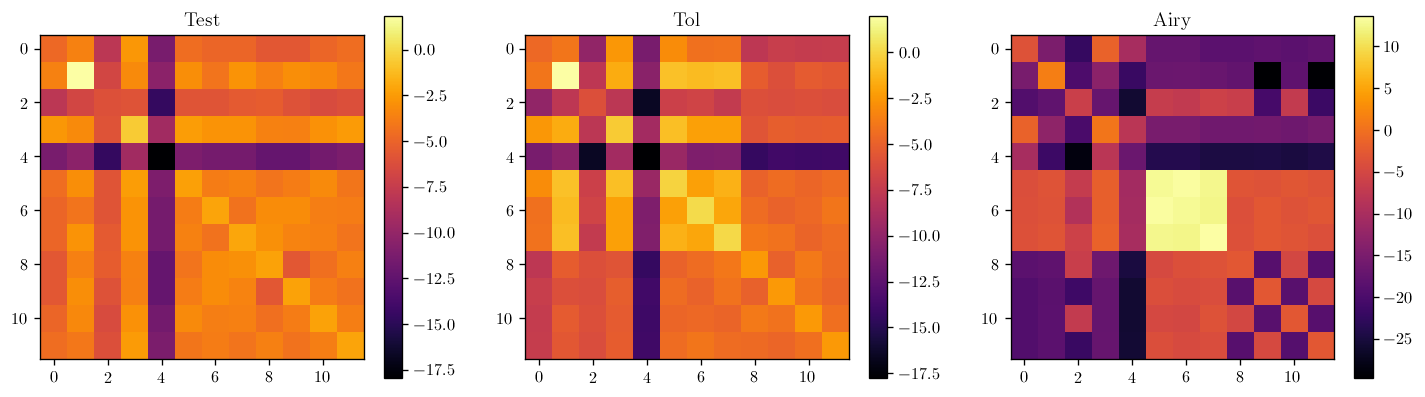

In [11]:
plt.figure(figsize=(20,4))
for i in tqdm(range(len(models))):
    plt.subplot(1, 4, i+1)
    plt.title(names[i])
    plt.imshow(np.log10(np.abs(covs[i])))
    plt.colorbar()
plt.show()

/Users/louis/mambaforge/envs/dlux/lib/python3.10/site-packages/chainconsumer/chainconsumer.py:346: RuntimeWarning: covariance is not positive-semidefinite.
  chain = np.random.multivariate_normal(mean, covariance, size=1000000)


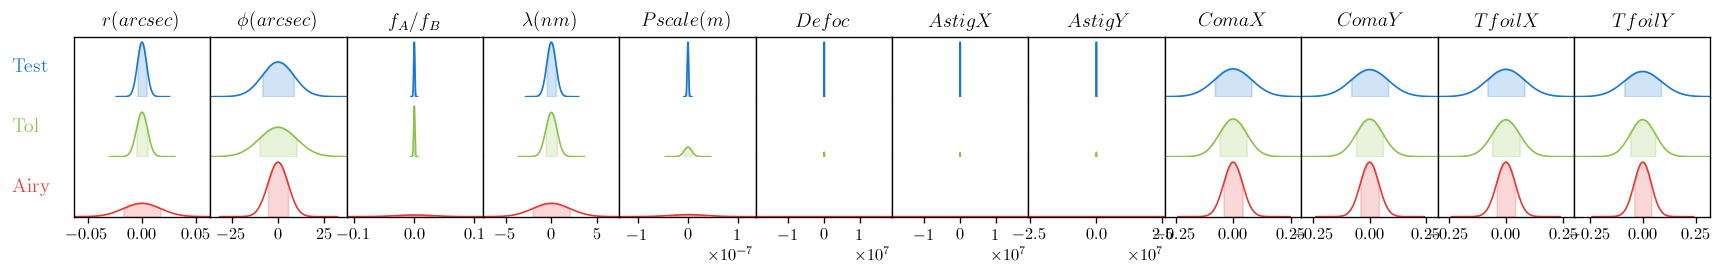

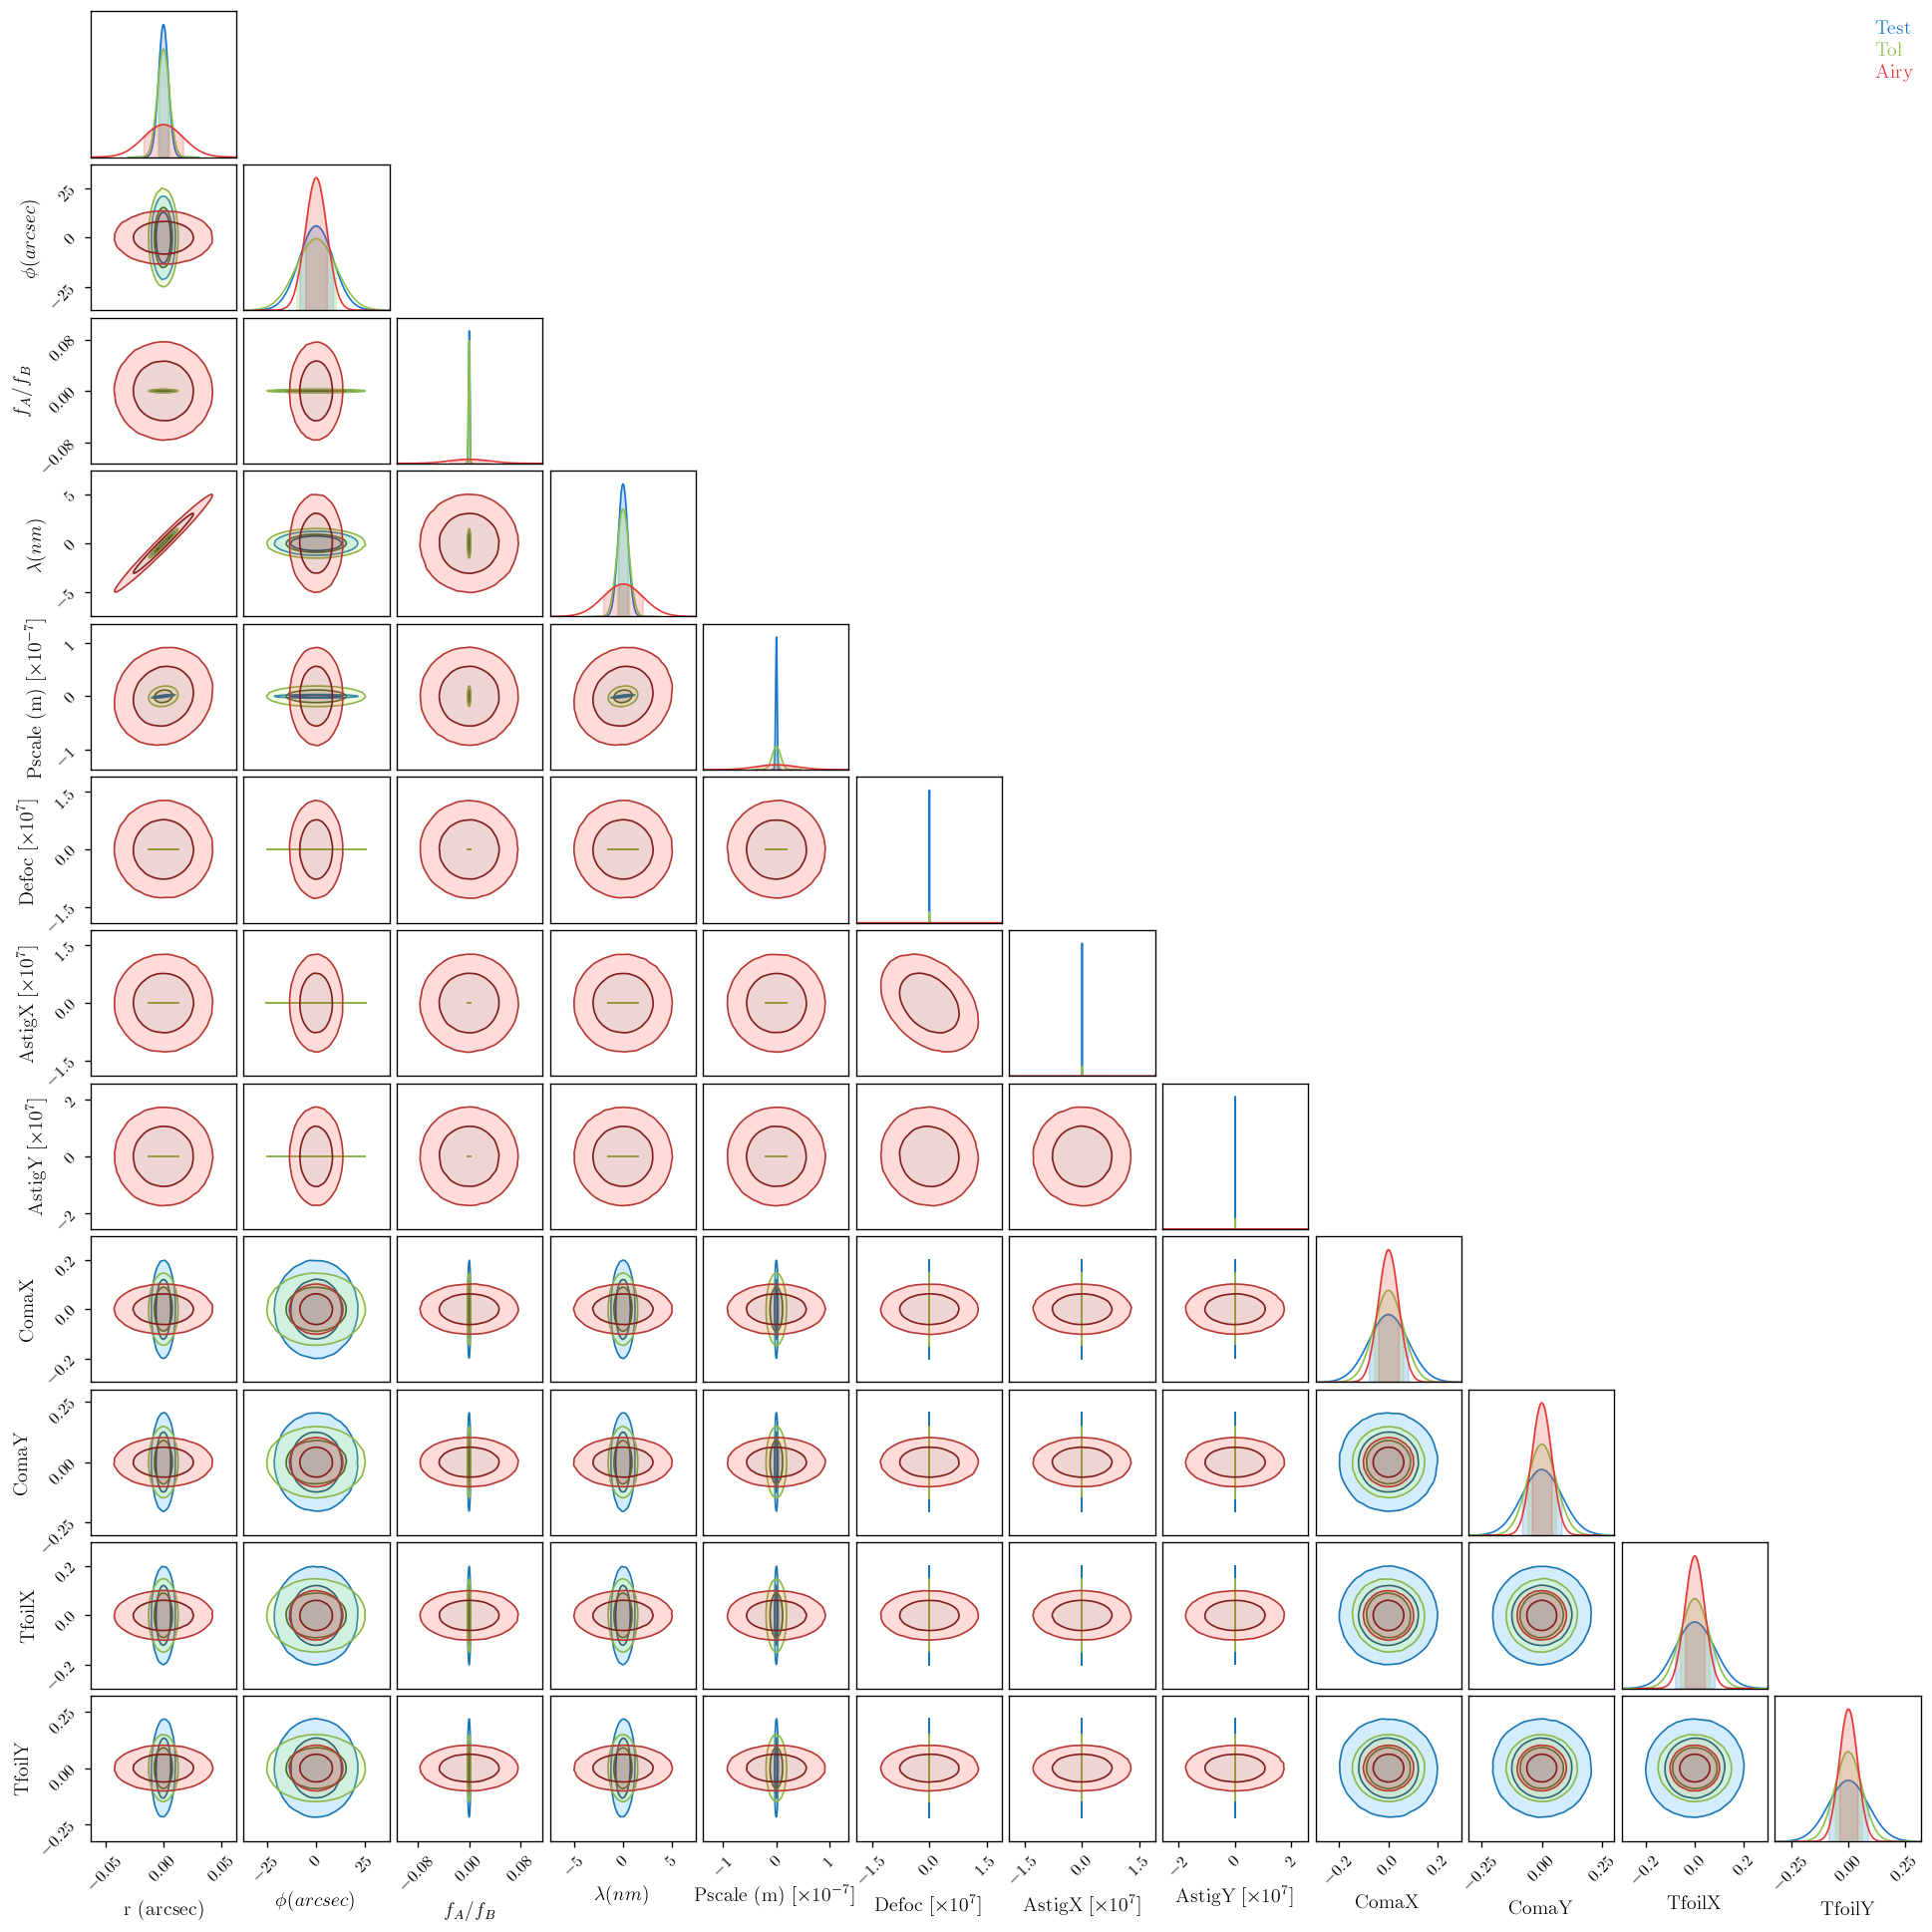

In [12]:
c = ChainConsumer()
for i in range(len(covs)):
    c.add_covariance(np.zeros(len(X)), covs[i], parameters=params, name=names[i])
    
c.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)

fig = c.plotter.plot_summary()
fig = c.plotter.plot()